In [1]:
# Default mount-path: /content/drive/Shared drives/Probstat

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [4]:
# root_path = './gdrive/Shared drives/Probstat'
root_path = './'

## SF Covid-19 Dataset

In [5]:
cases_df = pd.read_csv(root_path + '/data/COVID-19_Cases_Summarized_by_Date__Transmission_and_Case_Disposition.csv')

In [6]:
cases_df.isna().sum()

Date                     0
Transmission Category    0
Case Disposition         0
Case Count               0
dtype: int64

#### We can verify in above query, 0 MISSING values were found 

## Pre-processing steps for SF Covid-19 Dataset

1.   Converting Date column into date-time dtype



In [8]:
cases_df["Date"] = pd.to_datetime(cases_df["Date"], format="%Y/%m/%d")

In [9]:
# Verify by uncommenting and toggling with ascending=True/False
# cases_df.sort_values(by="Date", ascending=False)

## Crime Dataset

In [10]:
crime_df = pd.read_csv(root_path + '/data/Police_Department_Incident_Reports__2018_to_Present.csv')

In [11]:
crime_df.shape

(342936, 36)

In [12]:
crime_df.isna().sum()

Incident Datetime                                            0
Incident Date                                                0
Incident Time                                                0
Incident Year                                                0
Incident Day of Week                                         0
Report Datetime                                              0
Row ID                                                       0
Incident ID                                                  0
Incident Number                                              0
CAD Number                                               79225
Report Type Code                                             0
Report Type Description                                      0
Filed Online                                            269212
Incident Code                                                0
Incident Category                                          162
Incident Subcategory                                   

## Pre-processing steps for Crime Dataset:


### Considering only non-null columns and Incident columns

In [13]:
columns_to_consider = ["Incident Datetime", "Incident Date", "Incident Time", "Incident Year", "Incident Day of Week", "Report Datetime", "Row ID", "Incident ID", "Incident Number", "Report Type Code", "Report Type Description", "Incident Code", "Incident Category", "Incident Subcategory", "Incident Description", "Resolution", "Police District"]

In [14]:
crime_df = crime_df[columns_to_consider]

In [15]:
crime_df = crime_df[crime_df["Incident Category"].notna()]

In [16]:
# Verify whhether nulls are removed through the above query
# crime_df.isnull().sum()

In [17]:
crime_df["Incident Date"] = pd.to_datetime(crime_df["Incident Date"], format="%Y/%m/%d")

In [18]:
crime_df["Incident Datetime"] = pd.to_datetime(crime_df["Incident Datetime"], format="%Y/%m/%d %I:%M:%S %p")

In [19]:
crime_df.dtypes

Incident Datetime          datetime64[ns]
Incident Date              datetime64[ns]
Incident Time                      object
Incident Year                       int64
Incident Day of Week               object
Report Datetime                    object
Row ID                              int64
Incident ID                         int64
Incident Number                     int64
Report Type Code                   object
Report Type Description            object
Incident Code                       int64
Incident Category                  object
Incident Subcategory               object
Incident Description               object
Resolution                         object
Police District                    object
dtype: object

## Visualizations

In [20]:
crime_df.head(1)

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,Report Type Code,Report Type Description,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Police District
0,2020-02-03 14:45:00,2020-02-03,14:45,2020,Monday,2020/02/03 05:50:00 PM,89881675000,898816,200085557,II,Initial,75000,Missing Person,Missing Person,Found Person,Open or Active,Taraval


In [21]:
def convert_agg_df_into_flatten_df(df):
  df = df.reset_index()
  df.columns = [' '.join(col).strip() for col in df.columns.values]

  return df

# df = crime_df.groupby(['Incident Date'])['Incident Date'].agg(["count"]).reset_index()
# df.head()

## Un-Smoothened and Smoothened crime cases by day


1.   For smoothening purposes used Simple Moving Average spanning over a week


In [41]:
unique_crimes = crime_df.groupby(["Incident ID"]).agg({"Incident Date": "first"}).reset_index()
unique_crimes.head()

date_freq = unique_crimes["Incident Date"].value_counts().to_frame().reset_index()
date_freq = date_freq.rename(columns={"index": "date", "Incident Date": "count"})
date_freq = date_freq.sort_values(by="date")
date_freq.head()

,date,count
6,2018-01-01,427
490,2018-01-02,329
172,2018-01-03,367
72,2018-01-04,386
148,2018-01-05,372


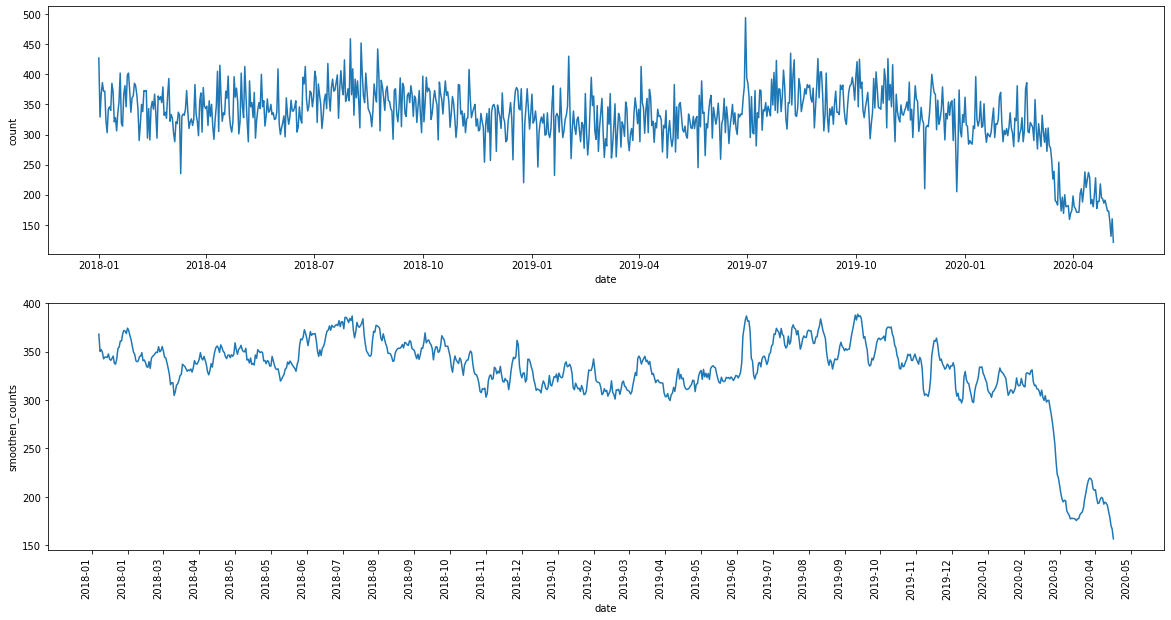

In [42]:
figure, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)
sns.lineplot(x='date', y='count', data=date_freq, ax=axes[0])


date_freq['smoothen_counts'] = date_freq['count'].rolling(window=7).mean()

sns_axes = sns.lineplot(x='date', y='smoothen_counts', data=date_freq, ax=axes[1])

# Adding x-ticks for each month
base_date = datetime.datetime.strptime('2018-01-01', '%Y-%m-%d')
dates = [base_date + datetime.timedelta(days=i * 30) for i in range(30)]
xfmt = mdates.DateFormatter('%Y-%m')
axes[1].xaxis.set_major_formatter(xfmt)
axes[1].set_xticks(dates)

x_dates = [date.strftime("%Y-%m") for date in dates]
remnant = axes[1].set_xticklabels(labels=x_dates, rotation=90, ha='right')

### As we can see there's huge drop after first week of March 2020.
#### Because the first case of corona in San-Francisco was observed in 5th March, after which social-distancing measures were implemented

## Sanity Checks

In [43]:
crime_df[crime_df["Report Type Description"] == "Coplogic Supplement"]["Report Type Code"].value_counts()

IS    8216
Name: Report Type Code, dtype: int64

In [44]:
crime_df[crime_df["Report Type Description"] == "Initial Supplement"]["Report Type Code"].value_counts()

IS    27882
Name: Report Type Code, dtype: int64

In [45]:
crime_df[crime_df["Report Type Description"] == "Vehicle Supplement"]["Report Type Code"].value_counts()

VS    11059
Name: Report Type Code, dtype: int64

In [46]:
crime_df[crime_df["Report Type Description"] == "Vehicle Initial"]["Report Type Code"].value_counts()

VI    16277
Name: Report Type Code, dtype: int64

In [47]:
crime_df[crime_df["Report Type Description"] == "Coplogic Initial"]["Report Type Code"].value_counts()

II    65508
Name: Report Type Code, dtype: int64

In [48]:
crime_df[crime_df["Report Type Description"] == "Initial"]["Report Type Code"].value_counts()

II    213832
Name: Report Type Code, dtype: int64

In [49]:
crime_df[crime_df["Report Type Description"] == "Initial Supplement"].head(1)

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,Report Type Code,Report Type Description,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Police District
6,2020-01-16 00:01:00,2020-01-16,00:01,2020,Thursday,2020/01/21 08:05:00 AM,89745215041,897452,200050964,IS,Initial Supplement,15041,Offences Against The Family And Children,Family Offenses,Elder Adult or Dependent Abuse (not Embezzleme...,Unfounded,Mission


In [50]:
crime_df[crime_df["Incident ID"] == 897452]
# Special case: 898713
# Special case: 898686

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,Report Type Code,Report Type Description,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Police District
6,2020-01-16 00:01:00,2020-01-16,00:01,2020,Thursday,2020/01/21 08:05:00 AM,89745215041,897452,200050964,IS,Initial Supplement,15041,Offences Against The Family And Children,Family Offenses,Elder Adult or Dependent Abuse (not Embezzleme...,Unfounded,Mission


In [51]:
crime_df[crime_df["Report Type Description"] == "Vehicle Supplement"].head(1)

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,Report Type Code,Report Type Description,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Police District
64,2020-02-03 03:22:00,2020-02-03,03:22,2020,Monday,2020/02/03 03:22:00 AM,89859907041,898599,200082359,VS,Vehicle Supplement,7041,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Auto",Open or Active,Bayview


In [52]:
crime_df[crime_df["Incident ID"] == 898599]

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,Report Type Code,Report Type Description,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Police District
64,2020-02-03 03:22:00,2020-02-03,03:22,2020,Monday,2020/02/03 03:22:00 AM,89859907041,898599,200082359,VS,Vehicle Supplement,7041,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Auto",Open or Active,Bayview


In [53]:
crime_df[crime_df["Report Type Description"] == "Coplogic Supplement"].head(1)

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,Report Type Code,Report Type Description,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Police District
119,2020-01-29 18:30:00,2020-01-29,18:30,2020,Wednesday,2020/02/01 07:21:00 PM,89864306244,898643,206022329,IS,Coplogic Supplement,6244,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Open or Active,Richmond


In [54]:
crime_df[crime_df["Incident ID"] == 898643]

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,Report Type Code,Report Type Description,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Police District
119,2020-01-29 18:30:00,2020-01-29,18:30,2020,Wednesday,2020/02/01 07:21:00 PM,89864306244,898643,206022329,IS,Coplogic Supplement,6244,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Open or Active,Richmond


In [58]:
vehicle_unique_reports = crime_df[(crime_df["Report Type Description"] == "Vehicle Initial") |
                                  (crime_df["Report Type Description"] == "Vehicle Supplement")]
vehicle_unique_reports = vehicle_unique_reports.groupby(["Incident ID"]).agg({"Incident Date": "first"}).reset_index()

online_unique_reports = crime_df[(crime_df["Report Type Description"] == "Coplogic Initial") |
                                             (crime_df["Report Type Description"] == "Coplogic Supplement")]
online_unique_reports = online_unique_reports.groupby(["Incident ID"]).agg({"Incident Date": "first"}).reset_index()

In [59]:
vehicle_stats = vehicle_unique_reports["Incident Date"].value_counts().to_frame().reset_index()
vehicle_stats = vehicle_stats.rename(columns={"index": "date", "Incident Date": "count"})
vehicle_stats = vehicle_stats.sort_values(by="date")
vehicle_stats['smoothen_counts'] = vehicle_stats['count'].rolling(window=7).mean()

online_stats = online_unique_reports["Incident Date"].value_counts().to_frame().reset_index()
online_stats = online_stats.rename(columns={"index": "date", "Incident Date": "count"})
online_stats = online_stats.sort_values(by="date")
online_stats['smoothen_counts'] = online_stats['count'].rolling(window=7).mean()

vehicle_stats["type"] = "vehicle"
online_stats["type"] = "online"

merged_df = pd.concat([vehicle_stats, online_stats])

In [60]:
merged_df = merged_df[merged_df["date"] > datetime.datetime(2019, 12, 31)]

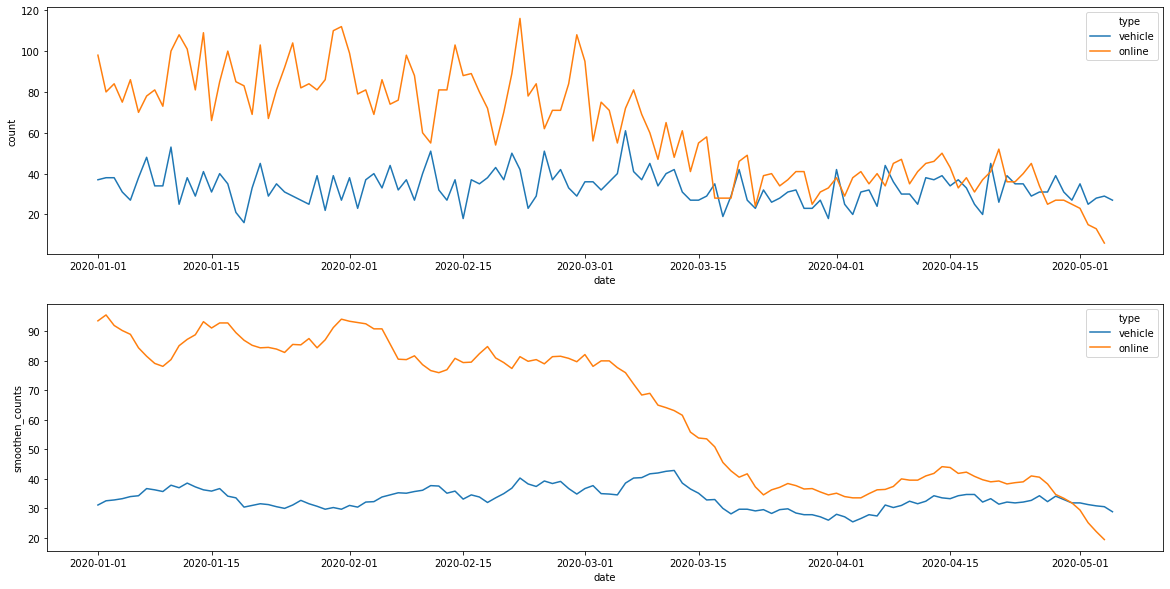

In [61]:
figure, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)
sns.lineplot(x='date', y='count', hue="type", data=merged_df, ax=axes[0])

sns_axes = sns.lineplot(x='date', y='smoothen_counts', hue="type", data=merged_df, ax=axes[1])